# Pytorch computer vision

Torchvision used for CV problems.

We can use pretrained models too (transfer learning)

* torchvision.transforsm for manipulating images
* torchvision.utils.data.Dataset is base dataset class for PyTorch
* torch.utils.data.DataLoader is a python iterable over dataset

In [ ]:
import torch
from torch import nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

print(torch.__version__)
print(torchvision.__version__)

2.3.1+cu121
0.18.1+cu121


# Model 1

## Creating dataset

Lots of datasets in `torchvision.datasets`.

`FashionMNIST` is used here.

In [ ]:
# training data
train_data = datasets.FashionMNIST(
    root="data", # where to download
    train=True, # we want the training set
    download=True,
    transform=torchvision.transforms.ToTensor(), # using tensor format
    target_transform=None
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)


In [ ]:
len(train_data), len(test_data)

(60000, 10000)

In [ ]:
# see some training samples
image, label = train_data[0]
image, label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
           0.2863, 0.0000, 0.0000, 0.0039, 

## Checking data contents

In [ ]:
class_names = train_data.classes
print(class_names)
print(image.shape, "|", label) # 1 color channel as grayscale

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
torch.Size([1, 28, 28]) | 9


## Visualize data

Image shape torch.Size([1, 28, 28])


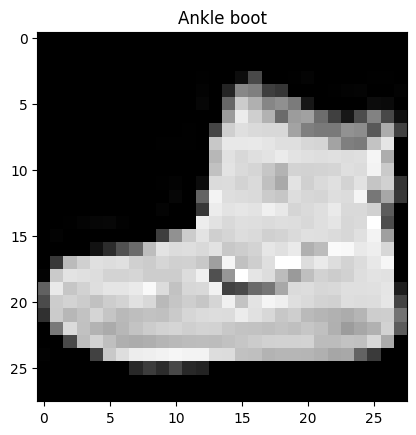

In [ ]:
# plot first image
image, label = train_data[0]
print(f"Image shape {image.shape}")
plt.imshow(image.squeeze(), cmap="gray") # matplotlib doens't want color dimension
plt.title(class_names[label]);

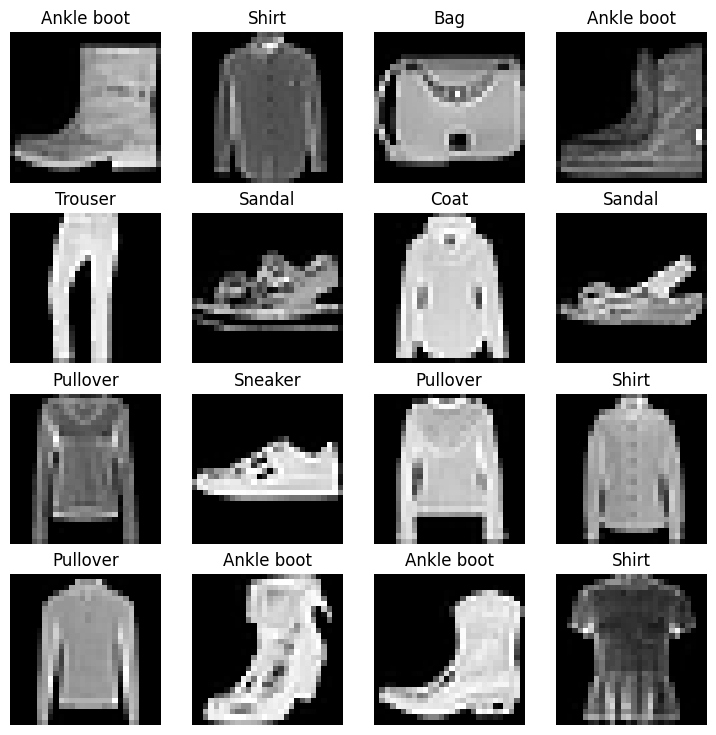

In [ ]:
# plot some more images
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
  rand_idx = torch.randint(0, len(train_data), size=[1]).item()
  img, label = train_data[rand_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap="gray")
  plt.title(class_names[label])
  plt.axis(False)

In [ ]:
train_data, test_data

(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor())

## Prepare DataLoader

Current data is in PyTorch Datasets format.

DataLoaders turn dataset into a Python iterable. We want data in batches or minibatches.

It is more computationally efficient to look at batches at a time, and gives the neural network more chances to update gradients per epoch.


In [ ]:
from torch.utils.data import DataLoader

# batch size hyperparameter
BATCH_SIZE = 32

# turn datasets into iterables
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              shuffle=False)

print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Lengths: {len(train_dataloader)}, {len(test_dataloader)} of batch size 32")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x79c77c96f0d0>, <torch.utils.data.dataloader.DataLoader object at 0x79c77c96f310>)
Lengths: 1875, 313 of batch size 32


In [ ]:
# batches
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Label 6


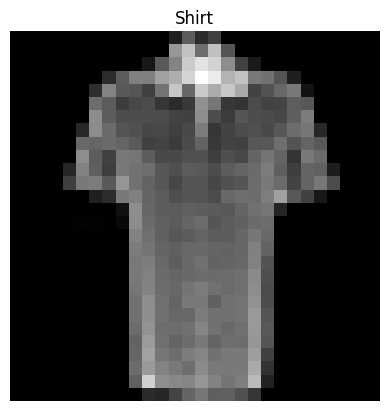

In [ ]:
# show a sample
torch.manual_seed(42)
rand_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[rand_idx], train_labels_batch[rand_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)
print(f"Label {label}")

## Build baseline model

`flatten` layer flattens a contiguous range of dims into a tensor.

linear layer will want a vector instead of multidimentional tensor.

https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html

In [ ]:
# create a flatten layer
flatten_model = nn.Flatten()

# get a sample to test flatten
x = train_features_batch[0]
print(x.shape)

# flatten a sample
output = flatten_model(x)

print("flattened: ", output.shape)

torch.Size([1, 28, 28])
flattened:  torch.Size([1, 784])


In [ ]:
class FashionMNISTModelV0(nn.Module):
  def __init__(self,
               input_shape:int,
               hidden_units: int,
               output_shape:int):
    super().__init__()
    self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape,
                      out_features=hidden_units),
            nn.Linear(in_features=hidden_units,
                      out_features=output_shape)
        )
  def forward(self, x):
    return self.layer_stack(x)

In [ ]:
torch.manual_seed(42)

model_0 = FashionMNISTModelV0(
    input_shape=784,
    hidden_units=10,
    output_shape=len(class_names)
).to("cpu")

model_0

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [ ]:
# test the forward of the model
dummy_x = torch.rand([1, 1, 28, 28])
print(model_0(dummy_x).shape)
print(model_0.state_dict())

torch.Size([1, 10])
OrderedDict([('layer_stack.1.weight', tensor([[ 0.0273,  0.0296, -0.0084,  ..., -0.0142,  0.0093,  0.0135],
        [-0.0188, -0.0354,  0.0187,  ..., -0.0106, -0.0001,  0.0115],
        [-0.0008,  0.0017,  0.0045,  ..., -0.0127, -0.0188,  0.0059],
        ...,
        [-0.0116,  0.0273, -0.0344,  ...,  0.0176,  0.0283, -0.0011],
        [-0.0230,  0.0257,  0.0291,  ..., -0.0187, -0.0087,  0.0001],
        [ 0.0176, -0.0147,  0.0053,  ..., -0.0336, -0.0221,  0.0205]])), ('layer_stack.1.bias', tensor([-0.0093,  0.0283, -0.0033,  0.0255,  0.0017,  0.0037, -0.0302, -0.0123,
         0.0018,  0.0163])), ('layer_stack.2.weight', tensor([[ 0.0614, -0.0687,  0.0021,  0.2718,  0.2109,  0.1079, -0.2279, -0.1063,
          0.2019,  0.2847],
        [-0.1495,  0.1344, -0.0740,  0.2006, -0.0475, -0.2514, -0.3130, -0.0118,
          0.0932, -0.1864],
        [ 0.2488,  0.1500,  0.1907,  0.1457, -0.3050, -0.0580,  0.1643,  0.1565,
         -0.2877, -0.1792],
        [ 0.2305, -0.2

### Loss optimizer and evaluation metrics

Loss function will be `nn.CrossEntropyLoss()`

Optimizer will be `torch.optim.SGD()`, stochastic gradient descent.

We'll evaluate with accuracy

In [ ]:
import requests
from pathlib import Path

# download helper functions py for accuracy method
if Path("helper_functions.py").is_file():
  print("already downloaded")
else:
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

already downloaded


In [ ]:
from helper_functions import accuracy_fn

# setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [ ]:
from timeit import default_timer as timer

# function to time our expiriments
def print_train_time(start: float,
                     end:float):
  total_time = end - start
  print(f"train time {total_time:.3f}")
  return total_time

### Create training loop on batches of data

Optimizer will update parameters once per batch rather than once per epoch :)

In [ ]:
# tqdm for progress bar
from tqdm.auto import tqdm

torch.manual_seed(42)
train_time_start_on_cpu = timer()

epochs = 3

# training loop
for epoch in tqdm(range(epochs)):
  print(f"\nEpoch {epoch}")
  train_loss = 0

  # loop through training batches
  for batch, (X, y) in enumerate(train_dataloader):
    model_0.train()
    # forward pass
    y_pred = model_0(X)

    # calculate loss per batch
    loss = loss_fn(y_pred, y)
    train_loss += loss

    # zero optimizer grad
    optimizer.zero_grad()

    # loss backward
    loss.backward()

    # optimizer step
    optimizer.step()

    # print stuff
    if batch % 400 == 0:
      print(f"{batch * len(X)}/{len(train_dataloader.dataset)} samples")

  # average loss per batch
  train_loss /= len(train_dataloader)

  # testing loop
  test_loss, test_acc = 0, 0
  model_0.eval() # eval mode
  with torch.inference_mode():
    for X_test, y_test in test_dataloader:
      # forward pass
      test_pred = model_0(X_test)

      # calculate loss sums
      test_loss += loss_fn(test_pred, y_test)

      # calculate accuracy
      test_acc += accuracy_fn(y_true = y_test,
                              y_pred=test_pred.argmax(dim=1))

    # claculate test loss average
    test_loss /= len(test_dataloader)
    # test accuracy per batch
    test_acc /= len(test_dataloader)

  print(f"train loss {train_loss:.4f} | test loss {test_loss:.4f} | test acc {test_acc:.4f}")

  train_time_end = timer()
  total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu,
                                              end = train_time_end)

  0%|          | 0/3 [00:00<?, ?it/s]


Epoch 0
0/60000 samples
12800/60000 samples
25600/60000 samples
38400/60000 samples
51200/60000 samples
train loss 0.5904 | test loss 0.5095 | test acc 82.0387
train time 15.419

Epoch 1
0/60000 samples
12800/60000 samples
25600/60000 samples
38400/60000 samples
51200/60000 samples
train loss 0.4763 | test loss 0.4799 | test acc 83.1969
train time 28.782

Epoch 2
0/60000 samples
12800/60000 samples
25600/60000 samples
38400/60000 samples
51200/60000 samples
train loss 0.4550 | test loss 0.4766 | test acc 83.4265
train time 41.916


## Predictions and Model 0 results

### eval model function

In [ ]:
torch.manual_seed(42)

# returns dictionary with results of model predicting on data_loader
def eval_model(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn):
  loss, acc = 0, 0
  model.eval() # eval mode
  with torch.inference_mode():
    for X, y in data_loader:
      # device agnostic
      X, y = X.to(device), y.to(device)

      # make predictions
      y_pred = model(X)

      # accumulate loss and acc per batch
      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_true=y,
                         y_pred=y_pred.argmax(dim=1))

    # scale loss and acc
    loss /= len(data_loader)
    acc /= len(data_loader)

    return {"model_name": model.__class__.__name__,
            "model_loss": loss.item(),
            "model_acc": acc}

model_0_results = eval_model(model=model_0,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn)

model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663894295692444,
 'model_acc': 83.42651757188499}

In [ ]:
# device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

# Model 2

Try to create better model with non-linearity

In [ ]:
class FashionMNISTModelV1(nn.Module):
  def __init__(self,
               input_shape:int,
               hidden_units: int,
               output_shape:int):
    super().__init__()
    self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape,
                      out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,
                      out_features=output_shape),
            nn.ReLU()
        )
  def forward(self, x):
    return self.layer_stack(x)

In [ ]:
# instance of model_1
torch.manual_seed(42)
model_1 = FashionMNISTModelV1(input_shape=784,
                              hidden_units=10,
                              output_shape=len(class_names)).to(device)
next(model_1.parameters()).device

device(type='cpu')

## Loss, optimizer, and evaluation metrics

(loss function measures how off the model is, optimizer updates model parameters to reduce loss)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

Functionize training and evaluation loops

In [ ]:
# functions for training loop and testing loop

def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):

  train_loss, train_acc = 0, 0

  # training mode
  model.train()

  # loop through training batches
  for batch, (X, y) in enumerate(train_dataloader):
    X, y = X.to(device), y.to(device)
    # forward pass
    y_pred = model(X)

    # calculate loss per batch
    loss = loss_fn(y_pred, y)
    train_loss += loss
    train_acc += accuracy_fn(y_true=y,
                             y_pred=y_pred.argmax(dim=1))

    # zero optimizer grad
    optimizer.zero_grad()

    # loss backward"
    loss.backward()

    # optimizer step
    optimizer.step()

  # average loss per batch
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train loss {train_loss:.5f} | Train acc {train_acc:.5f}%")


def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
  test_loss, test_acc = 0, 0
  model.eval() # eval mode

  with torch.inference_mode():
    for X, y in test_dataloader:
      X, y = X.to(device), y.to(device)

      # forward pass
      test_pred = model(X)

      # calculate loss sums
      test_loss += loss_fn(test_pred, y)

      # calculate accuracy
      test_acc += accuracy_fn(y_true=y,
                              y_pred=test_pred.argmax(dim=1))

    # claculate test loss average
    test_loss /= len(data_loader)
    # test accuracy per batch
    test_acc /= len(data_loader)

  print(f"test loss {test_loss:.4f} | test acc {test_acc:.4f}")


In [ ]:
torch.manual_seed(42)

# measure time
train_time_start = timer()
epochs = 3

# optimization and evaluation loop
for epoch in tqdm(range(epochs)):
  print(f"\nEpoch: {epoch}")
  train_step(model=model_1,
             data_loader=train_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy_fn,
             device=device)
  test_step(model=model_1,
            data_loader=test_dataloader,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            device=device)

  train_time_end = timer()
  model_1_time = print_train_time(start=train_time_start,
                                  end=train_time_end)

  0%|          | 0/3 [00:00<?, ?it/s]


Epoch: 0
Train loss 1.09199 | Train acc 61.34333%
test loss 0.9564 | test acc 64.9960
train time 14.318

Epoch: 1
Train loss 0.78101 | Train acc 71.92833%
test loss 0.7223 | test acc 73.9117
train time 27.596

Epoch: 2
Train loss 0.67027 | Train acc 75.93667%
test loss 0.6850 | test acc 75.0200
train time 40.922


In [ ]:
model_1_results = eval_model(model=model_1,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn)
model_1_results

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.6850009560585022,
 'model_acc': 75.01996805111821}

# Model 3: Build. Convolution Neural Network

* input layer
* convolution layer (convolutional layers figures out what features to learn)
* hidden activation layer
* pooling layer
* output layer

Can have several convolution, ReLU, or pooling layers

Interactive CNN visualization: https://poloclub.github.io/cnn-explainer

Conv2d: `out(Ni, Coutj)=bias(Coutj)+sum_(k=0) to Cin-1 (weight(Coutj, k)*input(Nik))`. From what I understand it's like sliding a layer of weights over different areas of the image and trying to get the greatest sum of products. `*` is cross-correlation operator. https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

Maxpool 2d: Downsamples the input along its spatial dimensions (height and width) by taking the maximum value over an input window for each channel of the input. The window is shifted by strides along each dimension. https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html

Images basically get compressed through the layer until feature vector is created.

In [ ]:
# create CNN
class FashionMNISTModelV2(nn.Module):
  # model architecture to replicate TinyVGG model from CNN explanation site
  def __init__(self,
             input_shape: int,
             hidden_units: int,
             output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1), # these params are the hyperparameters
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.MaxPool2d(kernel_size=2)
    )
    # i guess classifier (output layer) needs flatten but conv layers don't
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units * 7 * 7, # flatten changes matrice dimensions, so this accounts for it
                  out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    # print(x.shape)
    x = self.conv_block_2(x)
    x = self.classifier(x)
    return x


In [ ]:

torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape=1, # 1 color channel
                              hidden_units=10,
                              output_shape=len(class_names)).to(device)


## Stepping through `nn.Conv2d`

In [ ]:
torch.manual_seed(42)

# batch of images
images = torch.randn(size=(32, 3, 64, 64))
test_image = images[0]
print(f"Image batch shape {images.shape}")
print(f"Shape {test_image.shape}")
print(f"Test image\n {test_image}")

Image batch shape torch.Size([32, 3, 64, 64])
Shape torch.Size([3, 64, 64])
Test image
 tensor([[[ 1.9269,  1.4873,  0.9007,  ...,  1.8446, -1.1845,  1.3835],
         [ 1.4451,  0.8564,  2.2181,  ...,  0.3399,  0.7200,  0.4114],
         [ 1.9312,  1.0119, -1.4364,  ..., -0.5558,  0.7043,  0.7099],
         ...,
         [-0.5610, -0.4830,  0.4770,  ..., -0.2713, -0.9537, -0.6737],
         [ 0.3076, -0.1277,  0.0366,  ..., -2.0060,  0.2824, -0.8111],
         [-1.5486,  0.0485, -0.7712,  ..., -0.1403,  0.9416, -0.0118]],

        [[-0.5197,  1.8524,  1.8365,  ...,  0.8935, -1.5114, -0.8515],
         [ 2.0818,  1.0677, -1.4277,  ...,  1.6612, -2.6223, -0.4319],
         [-0.1010, -0.4388, -1.9775,  ...,  0.2106,  0.2536, -0.7318],
         ...,
         [ 0.2779,  0.7342, -0.3736,  ..., -0.4601,  0.1815,  0.1850],
         [ 0.7205, -0.2833,  0.0937,  ..., -0.1002, -2.3609,  2.2465],
         [-1.3242, -0.1973,  0.2920,  ...,  0.5409,  0.6940,  1.8563]],

        [[-0.7978,  1.0261, 

Test single convolutional layer

In [ ]:
# test a single conv layer
conv_layer = nn.Conv2d(in_channels=3,
                       out_channels=10,
                       kernel_size=(3,3),
                       stride=1,
                       padding=1)
# pass data through
conv_output = conv_layer(test_image.unsqueeze(0))
print(conv_output, "\n", conv_output.shape)

tensor([[[[ 1.6446e-01, -6.2518e-01, -7.7713e-01,  ..., -3.2504e-01,
           -3.1604e-01,  4.5352e-01],
          [ 3.5455e-01, -2.8778e-01, -6.0596e-02,  ...,  6.6224e-01,
           -2.3216e-01,  7.7080e-01],
          [-4.5420e-02, -9.8911e-01, -4.0099e-01,  ..., -1.8552e-01,
           -5.7622e-01,  4.2301e-01],
          ...,
          [ 2.9288e-01, -1.4512e-01, -1.1566e-01,  ..., -3.6626e-01,
            3.5645e-01,  2.8384e-01],
          [ 2.0746e-01,  3.6096e-02,  1.5214e-01,  ..., -4.9680e-01,
           -7.2258e-01, -8.3858e-02],
          [-3.2457e-01, -3.2326e-01,  9.5475e-02,  ...,  5.9960e-01,
            3.2819e-01,  3.6604e-01]],

         [[ 1.2406e+00,  2.2794e-01, -1.8362e-01,  ..., -6.3520e-01,
           -7.5413e-01,  4.0612e-01],
          [ 4.1380e-01, -1.0853e+00, -1.6079e+00,  ..., -1.7643e+00,
            2.5263e-01,  3.8844e-01],
          [ 5.3442e-01, -8.2507e-01,  6.3866e-01,  ...,  4.8068e-01,
            8.4869e-01, -1.5706e-01],
          ...,
     

## Stepping through `nn.maxPool2d()`

Basically takes max of filter area I think?

In [ ]:
test_image.shape

torch.Size([3, 64, 64])

In [ ]:
# sample max pool layer
max_pool_layer = nn.MaxPool2d(kernel_size=2)

test_image_through_conv = conv_layer(test_image.unsqueeze(dim=0))
print(f"Shape after conv {test_image_through_conv.shape}")

# pass through max pool
test_image_conv_and_pool = max_pool_layer(test_image_through_conv)
print(f"Shape after conv and pool {test_image_conv_and_pool.shape}")

Shape after conv torch.Size([1, 10, 64, 64])
Shape after conv and pool torch.Size([1, 10, 32, 32])


In [ ]:
torch.manual_seed(42)
# random tensor
random_tensor = torch.rand(size=(1, 1, 2, 2))
print(f"Random pool tensor {random_tensor}")
print(f"Random pool tensor shape {random_tensor.shape}")

# max pool layer
max_pool_layer = nn.MaxPool2d(kernel_size=2)
max_pool_tensor = max_pool_layer(random_tensor)

print(f"Max pool tensor {max_pool_tensor}")
print(f"Max pool tensor shape {max_pool_tensor.shape}")

Random pool tensor tensor([[[[0.8823, 0.9150],
          [0.3829, 0.9593]]]])
Random pool tensor shape torch.Size([1, 1, 2, 2])
Max pool tensor tensor([[[[0.9593]]]])
Max pool tensor shape torch.Size([1, 1, 1, 1])


Pass through dummy data through whole model for testing

In [ ]:
rand_image_tensor = torch.randn(size=(1, 28, 28))
model_2(rand_image_tensor.unsqueeze(0))

tensor([[ 0.0330, -0.0462,  0.0494, -0.0067, -0.0493,  0.0068,  0.0440, -0.0504,
          0.0056, -0.0581]], grad_fn=<AddmmBackward0>)

## Setup loss function and optimizer

In [ ]:
# Setup loss function and optimizer

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.1)

## Training and testing

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# measure time
from timeit import default_timer as timer
train_start_model2 = timer()

# train and test models
epochs = 3
for epoch in tqdm(range(epochs)):
  print(f"\nEpoch {epoch}")
  train_step(model=model_2,
             data_loader=train_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy_fn,
             device=device)
  test_step(model=model_2,
            data_loader=test_dataloader,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            device=device)
  train_end_model2 = timer()
  total_train_time_model2 = print_train_time(start=train_start_model2,
                                             end=train_end_model2)


  0%|          | 0/3 [00:00<?, ?it/s]


Epoch 0
Train loss 0.52635 | Train acc 81.02333%
test loss 0.3797 | test acc 86.4217
train time 62.606

Epoch 1
Train loss 0.34611 | Train acc 87.59333%
test loss 0.3357 | test acc 87.8894
train time 123.067

Epoch 2
Train loss 0.31026 | Train acc 88.88000%
test loss 0.3052 | test acc 88.9876
train time 183.494


In [ ]:
# get model 2 results
model_2_results = eval_model(
    model=model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
)

model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.30516013503074646,
 'model_acc': 88.9876198083067}

## Compare model results and training time

In [ ]:
import pandas as pd
compare_results = pd.DataFrame([model_0_results,
                                model_1_results,
                                model_2_results])

compare_results

,model_name,model_loss,model_acc
0,FashionMNISTModelV0,0.476639,83.426518
1,FashionMNISTModelV1,0.685001,75.019968
2,FashionMNISTModelV2,0.305160,88.987620


In [ ]:
compare_results["training_time"] = [total_train_time_model_0,
                                    model_1_time,
                                    total_train_time_model2]
compare_results

,model_name,model_loss,model_acc,training_time
0,FashionMNISTModelV0,0.476639,83.426518,41.916186
1,FashionMNISTModelV1,0.685001,75.019968,40.921578
2,FashionMNISTModelV2,0.305160,88.987620,183.493920


## Make and evaluate random predictions with best model

In [ ]:
def make_predictions(model: torch.nn.Module,
                     data:list,
                     device: torch.device = device):
  pred_probs = []
  model.eval()
  with torch.inference_mode():
    for sample in data:
      # prepare sample and pass to device
      sample = torch.unsqueeze(sample, dim=0).to(device)

      # forward pass
      pred_logit = model(sample)

      # get prediction probs
      pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

      pred_probs.append(pred_prob.cpu())

  return torch.stack(pred_probs)

In [ ]:
import random
random.seed(42)

test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), k=9):
  test_samples.append(sample)
  test_labels.append(label)

print(test_samples[0].shape, class_names[test_labels[0]])

torch.Size([1, 28, 28]) Sandal


In [ ]:
# make predictions
pred_probs = make_predictions(model=model_2,
                              data=test_samples)

# view first 2 predcition probabilities
pred_probs[:2]

tensor([[3.1545e-08, 3.5573e-10, 3.4101e-08, 1.6605e-09, 3.9623e-09, 9.9998e-01,
         6.9774e-07, 4.0546e-07, 6.6000e-07, 1.8525e-05],
        [7.0301e-02, 2.4456e-01, 1.0362e-03, 6.3726e-01, 8.4213e-03, 3.8376e-05,
         3.5947e-02, 1.9549e-03, 9.2847e-05, 3.9006e-04]])

In [ ]:
# convert prediction probabilities to labels
pred_classes = pred_probs.argmax(dim=1)
pred_classes, test_labels

(tensor([5, 3, 7, 4, 3, 0, 4, 7, 1]), [5, 1, 7, 4, 3, 0, 4, 7, 1])

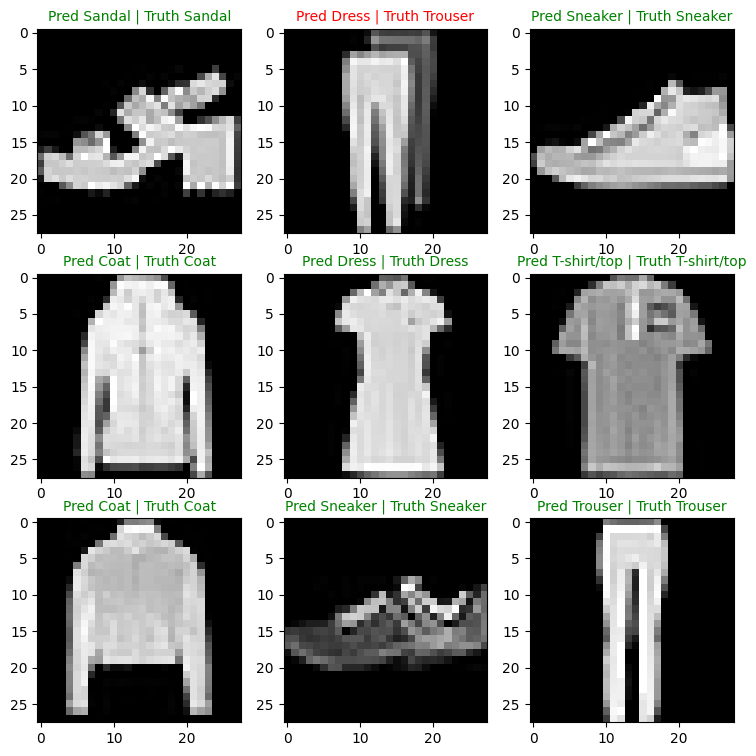

In [ ]:
# plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3

for i, sample in enumerate(test_samples):
  # create subplot
  plt.subplot(nrows, ncols, i+1)

  # plot target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # get prediction label
  pred_label = class_names[pred_classes[i]]

  # get truth label
  truth_label = class_names[test_labels[i]]

  # title for plot
  title_text = f"Pred {pred_label} | Truth {truth_label}"
  if pred_label == truth_label:
    plt.title(title_text, fontsize = 10, c="g")
  else:
    plt.title(title_text, fontsize = 10, c="r")

## Make confusion matrix for further evaluation

Good sample code here: https://rasbt.github.io/mlxtend/user_guide/plotting/plot_confusion_matrix/

In [ ]:
from tqdm.auto import tqdm

# make predictions with trained model for all test data
y_preds = []
model_2.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Predictions"):
    X, y = X.to(device), y.to(device)
    # forward pass
    y_logit = model_2(X)
    # get prediction probs
    y_pred = torch.softmax(y_logit.squeeze(), dim=0).argmax(dim=1)
    y_preds.append(y_pred.cpu())

print(y_preds)
y_pred_tensor = torch.cat(y_preds)
y_pred_tensor[:10]


Predictions:   0%|          | 0/313 [00:00<?, ?it/s]

[tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7, 4, 5, 5, 3, 4, 1, 2, 6, 8, 0, 2, 5, 7, 5,
        1, 6, 6, 0, 9, 3, 8, 8]), tensor([3, 3, 8, 0, 7, 5, 7, 9, 6, 1, 3, 7, 6, 7, 2, 1, 4, 6, 4, 6, 5, 8, 2, 2,
        8, 4, 8, 0, 7, 7, 8, 5]), tensor([1, 3, 3, 4, 7, 8, 7, 0, 2, 6, 4, 3, 1, 2, 8, 4, 3, 8, 5, 9, 5, 0, 3, 2,
        0, 2, 5, 3, 6, 7, 1, 8]), tensor([0, 1, 6, 2, 3, 6, 7, 6, 7, 8, 5, 7, 9, 4, 2, 5, 7, 0, 5, 2, 8, 4, 7, 8,
        0, 0, 9, 9, 3, 0, 8, 6]), tensor([1, 5, 4, 1, 9, 1, 8, 6, 2, 1, 2, 5, 1, 6, 0, 0, 1, 6, 1, 3, 2, 2, 3, 4,
        1, 3, 5, 0, 4, 7, 9, 3]), tensor([8, 2, 3, 8, 0, 9, 4, 8, 8, 2, 6, 5, 6, 1, 2, 1, 3, 0, 8, 1, 0, 8, 3, 6,
        7, 9, 9, 4, 4, 7, 1, 2]), tensor([3, 6, 3, 2, 8, 3, 6, 1, 1, 0, 2, 9, 2, 4, 0, 7, 9, 8, 4, 1, 8, 4, 1, 3,
        1, 6, 7, 2, 8, 5, 6, 0]), tensor([7, 7, 6, 6, 7, 0, 7, 8, 9, 2, 9, 0, 5, 1, 4, 4, 5, 4, 9, 2, 2, 8, 6, 4,
        6, 2, 9, 7, 6, 5, 5, 4]), tensor([8, 5, 2, 3, 0, 4, 8, 6, 0, 6, 3, 8, 9, 6, 1, 3, 0, 2, 3, 0, 8, 3, 7, 4,
       

tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7])

In [ ]:
# install torchmetrics if not installed
try:
  import torchmetrics
except:
  !pip install -q torchmetrics -U mlxtend
  import torchmetrics, mlxtend
  print(f"version {mlxtend.__version__}")

We want the diagnols on confusion matrix to be dark/have highest values because that means the predictions match the true labels.

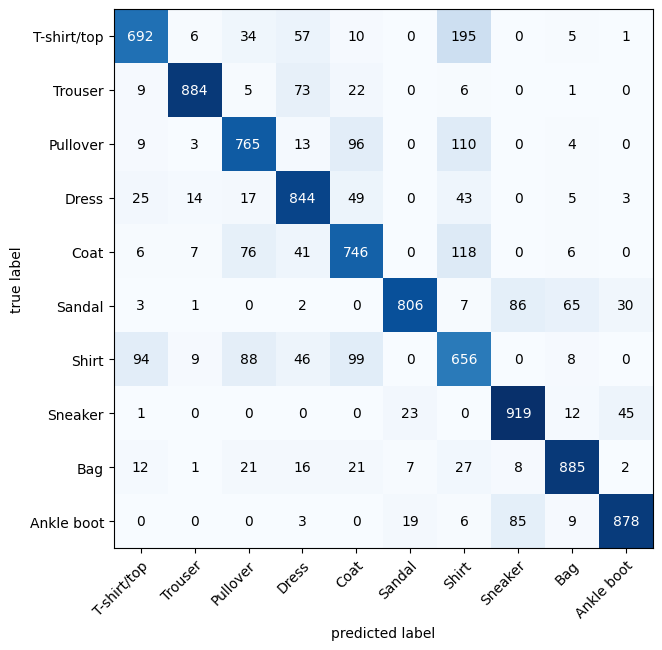

In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

# plot confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10, 7)
)

# Save our best model

In [ ]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)

MODEL_NAME = "03_pytorch_computer_vision_CNN_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

torch.save(obj=model_2.state_dict(),
           f=MODEL_SAVE_PATH)